In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

The fundamental equation governing our climate model is
$$c_p \frac{\partial T}{\partial t}(\varphi) = S(\varphi)\left[1 - \alpha(\varphi)\right] - \left(1 - \frac{\epsilon}{2}\right)\sigma T^4(\varphi) + D\frac{\partial^2 T}{\partial\varphi^2}(\varphi)$$
where $T$ is the surface temperature. Since the heat capacity $c_p$ will be multiplied by the time step $\mathrm{d}t$, which is a free parameter, we neglect $c_p$ in what follows.

## Parameters and Constants ##

In [52]:
n_lats = 2000
dt = 0.00001
eps = 0.75
S_0 = 1362
D = 0.01
sigma = 5.67e-8

Next, we create the latitude array and note the latitude step size.

In [53]:
phi = np.linspace(-np.pi / 2, np.pi / 2, n_lats)
dphi = phi[1] - phi[0]

Here is where we can change the initial temperature to see what equilibria can be reached depending on initial conditions.

In [54]:
T_0 = 285 * np.ones(phi.shape)

## Insolation and Albedo ##
The first thing we need to do is determine the insolation as a function of latitude $\varphi$ and obliquity $\beta$. This is mostly a question of geometry. For now, we omit assume $\beta = 0$ so that there is no axial tilt.

In [55]:
S = S_0 * np.cos(phi)

Next, we define an albedo function. For simplicity, we set
$$\alpha(\varphi) = \begin{cases}
0.3 & T(\varphi) > 273\textrm{ K} \\
0.6 & T(\varphi) \leq 273 \textrm{ K}
\end{cases}$$
In other words, when the temperature falls below freezing, the albedo jumps from $0.3$ to $0.6$.

In [56]:
def albedo(T):
    alpha = np.zeros(T.shape)
    alpha[T > 273] = 0.3
    alpha[T <= 273] = 0.6
    
    return alpha

## Estimating Derivatives in $\varphi$ ##

The last thing we need before we can begin seeking equilibria is some way to estimate $T_{\varphi\varphi}$. For latitudes in the interior of the domain, we can use a centered finite difference approximation:
$$\frac{\partial^2 T}{\partial\varphi^2}(\varphi) \approx \frac{T(\varphi + \mathrm{d}\varphi) - 2T(\varphi) + T(\varphi - \mathrm{d}\varphi)}{(\mathrm{d}\varphi)^2}$$
Then we just use the appropriate second-order forward/backward forward/backward difference at the edges. For convenience, we wrap the calculation of derivatives in with multiplication by $D$ in a single function to compute the diffusion term.

In [57]:
def diffusion(T):
    out = np.zeros(T.shape)
    out[0] = (T[2] - 2 * T[1] + T[0]) / (dphi ** 2)
    out[1:-1] = (T[:-2] - 2 * T[1:-1] + T[2:]) / (dphi ** 2)
    out[-1] = (T[-1] - 2 * T[-2] + T[-3]) / (dphi ** 2)
    
    return D * out

## Iterating Towards Equilibrium ##

Now we implement a loop to step the provided initial temperature towards equilibrium.

Iteration 100000: 46.81717192724002
Iteration 200000: 32.88906663992417
Iteration 300000: 38.39713255217977
Iteration 400000: 55.20912684822139
Iteration 500000: 75.31860442415298


KeyboardInterrupt: 

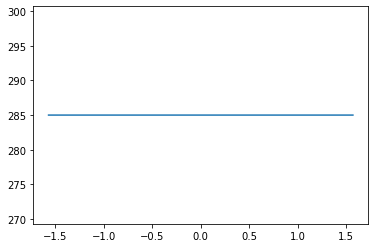

In [58]:
%matplotlib inline
_, ax = plt.subplots()
ax.plot(phi, T_0)


def equilibriate(T_0, max_iter=1e6):
    T = T_0
    dTdt = np.inf * np.ones(T.shape)
    
    n_iter = 0
    while abs(dTdt).max() > 1e-2 and n_iter < max_iter:
        dTdt = (
            S * (1 - albedo(T)) -
            (1 - 0.5 * eps) * sigma * (T ** 4) +
            diffusion(T)
        )
        
        T = T + dTdt * dt
        n_iter = n_iter + 1
        
        if n_iter % int(max_iter / 10) == 0:
            print(f'Iteration {n_iter}: {abs(dTdt).max()}')
            
    return T

T = equilibriate(T_0)
ax.plot(phi, T)